<br />
<div align="center">
  <a href="https://www.davivienda.com/wps/portal/personas/nuevo">
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" alt="Logo" width="300" height="100">
  </a>

  <h2 align="center"> Prueba Técniva Davivienda - Profesional I Data no Estructurada</h2>
  <h2 align="center"> Notebook de Implementación</h2>
  <h4 align="center"> Luvan Tabares </h4>
    
***

  <p align="center">
    Extraer la extracción de información necesaria para aumentar la eficiencia operativa, disminuir tiempos de respuesta y mitigar riesgos asociados a los procesos, la información solicitada será el nombre del cliente, la ciudad del cliente, fecha en la que se adquirió el compromiso y el monto que debe pagar. Para este análisis se utilizarán técnicas de procesamiento de lenguaje natural (NLP) para el procesamiento del texto y encontrar la mejor forma de extraer cada información solicitada a partir de un archivo csv que contiene dicha información.  </p>
</div>


* [1. EDA - Análisis Exploratorio de Datos](#topic1)
* [2. Extracción de Nombres](#topic2)
* [3. Extracción de Fechas](#topic3)
* [4. Extracción de Montos](#topic4)
* [5. Extracción de Ciudades](#topic5)
* [6. Resultados Finales y Conclusiones](#topic6)


### Instalación de librerías

Comandos necesarios para la instalación de las librerías utilizadas en este documento, se utilizó el modelo de lenguaje en español grande de spacy para mejorar la detección de las entidades requeridas

In [1]:
# conda install -c conda-forge pandas==1.2.3
# conda install -c conda-forge spacy==3.4.4
# !pip uninstall numpy
# !pip install numpy
# !python -m spacy download es_core_news_lg --user
# !pip install -U scikit-learn --user
# !pip install matplotlib --user


## Librerías necesarias

Las librerías utilizadas serán 'pandas' para el manejo de los archivos csv y su texto, 'spacy' para la tokenización y todos los procesos de nlp que se apliquen, librería 're' para el uso de expresiones regulares, 'datetime' para la manipulación del formato de fechas.

In [2]:
import numpy as np
import pandas as pd
import spacy
import re
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import csr_matrix
nlp = spacy.load('es_core_news_lg')


## 1. **EDA - Análisis Exploratorio de Datos**

Comenzar con el análisis de la información suministrada, importar el documento teniendo en cuenta el tipo de separador y dar un vistazo al documento

In [3]:
df = pd.read_csv('database/documentos.csv', '|')

Se observa un documento de dos columnas y 499 filas, dónde la primer columna (indx 0) es el document_name o nombre del documento, que son números asociados a cada texto, y la segunda columna (indx 1) es la que contiene el texto que nos interesa procesar.

In [4]:
df.head()

,document_name,document
0,86,Señor/señora: Daniel Roberto Torres Gómez L...
1,470,Atención: Ana Miguel Jiménez Rodríguez Le e...
2,16,Oiga!!!! Juan Pablo Fernández Muñoz Esperam...
3,165,"Querido/a Carlos Miguel Pérez Pérez, Espera..."
4,114,Estimadisimo/a Daniel Cristina Rodríguez Gon...


In [5]:
df.shape

(499, 2)

Al analizar uno de los textos se observa que se encuentra la información de interés como nombre, monto, fecha y ciudad, el orden de estos no siempre es así, teniendo casos en los que el nombre se encuentra al final o no existe una ciudad de residencia.

In [6]:
df['document'][1] # Exploramos uno de los textos a analizar

'  Atención: Ana Miguel Jiménez Rodríguez  Le escribimos para informarle que tiene un saldo a favor nuestro de £ 6,487,447,022.84 en su cuenta con nuestra empresa. Como puede recordar, tomó un préstamo con nosotros para   adquirir un auto de lujo Bentley Aventador en San Andrés. A pesar de múltiples intentos de ponerse en contacto con usted y recordarle su deuda pendiente, no hemos recibido ninguna respuesta   ni pago de su parte. Por lo tanto, solicitamos que devuelva el auto a nosotros o pague la totalidad de su deuda lo antes posible. Si no toma medidas en este asunto,   nos veremos obligados a iniciar acciones legales para recuperar la totalidad de su deuda.     Le instamos a que se ponga en contacto con nosotros lo antes posible para   discutir acuerdos de pago y evitar acciones legales adicionales, su deuda esta desde el 01/22/2016.     Si está experimentando dificultades financieras y no puede pagar la   totalidad de su deuda en este momento, no dude en ponerse en contacto con n

## Estudio de palabras

Para este análisis se llamarán las Stop Words a una variable stopwords para un manejo más simple, pero sólo será utilizado en este apartado

In [7]:
stopwords = nlp.Defaults.stop_words

Creamos la variable stopwords

In [8]:
n_vocab=1500
tf_vectorizer = CountVectorizer(max_df=0.8, min_df=2, max_features=n_vocab, stop_words=list(stopwords), ngram_range=(1,3)) # Al igual que un modelo, defino el objeto que construirá la matriz
tf = tf_vectorizer.fit_transform(df.document)
tf_feature_names = tf_vectorizer.get_feature_names_out() 

In [9]:
TF_detallada=pd.DataFrame(csr_matrix(tf).todense(), columns=tf_feature_names)

In [10]:
frecuencias=pd.DataFrame(TF_detallada.sum(), index=tf_feature_names, columns=['Freq'])
frecuencias.sort_values(by=['Freq'], ascending=False, inplace=True)
frecuencias.head(15)

,Freq
legales,720
monto,630
contacto,618
monto deuda,530
encontrar,498
encontrar solución,498
solución,498
acciones legales,460
acciones,460
ponerse,457


Se obtienen las palabras más comunes que no sean Stop Words, con esta información se podría estar contemplando eliminar manualmente o agregar estas palabras a las Stop Words para sacarlas del texto, lastimosamente esto se intentó pero no se vió mejoría en los resultados obtenidos.

<AxesSubplot:>

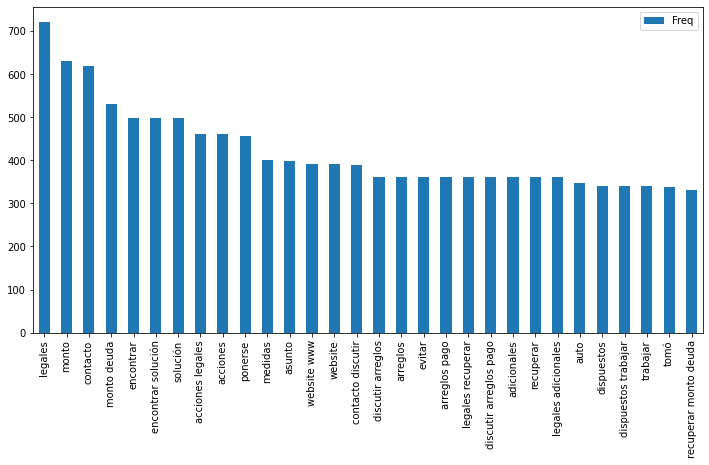

In [11]:
frecuencias.head(30).plot(kind='bar', figsize=(12,6))

Se presenta una tabla con las palabras más comunes

## Funciones necesarias

Dentro de la teoría básica de procesamiento de lenguaje natural nos encontraremos con las siguientes opciones de preprocesamiento:

1.Tokenización
2.Convertir texto a minúsculas 
3.Remover palabras de parada/artículos (Stop Words)
4.Remover puntuación
5.Estemización
6.Lematización

Para la tokenización se usará la librería 'spacy' y siempre se necesitará tokenizar el texto para su análisis, las otras opciones de preprocesamiento pueden ser usadas o no dependiendo de cómo se comporte el modelo, ya que para el análisis de este documento se observó que convertir a minúsculas llevaba a un error mayor en la identificación de las palabras (NER) y para cierta extracción de información se pueden usar diferentes combinaciones de preprocesamiento.

In [12]:
def remove_url(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.like_url])

def remove_stop(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])


Para este caso de análisis se observó que remover puntuación, convertir a minúsculas y lematizar empeoraban la capacidad de detección de entidades (NER) de spacy, muy probablemente por que para la detección analiza si las palabras empiezan por letra mayúscula y la puntuación y no lematizar le ayudan a detectar mejor el contexto. No se contempló usar estemización ya que conlleva a la creación de palabras que no existen el idioma, en un intento de obtener la raíz de la palabra.

# 2. Extracción de Nombres

Como primer paso de extracción se realizará la extracción de los nombres presentes en el documento, la librería spacy los detectará con la etiqueta 'PER' y analizando los documentos se observó que los nombres empiezan por letra mayúscula y son nombre compuestos, es decir dos nombres dos apellidos, pero se tuvo en cuenta el caso de personas con un sólo nombre

In [13]:
nlp.Defaults.stop_words.add('hola')
nlp.Defaults.stop_words.add('estimado')
nlp.Defaults.stop_words.add('estimada')
nlp.Defaults.stop_words.add('estimadísimo')
nlp.Defaults.stop_words.add('estimadísima')
nlp.Defaults.stop_words.add('don')
nlp.Defaults.stop_words.add('doña')
nlp.Defaults.stop_words.add('amigo')
nlp.Defaults.stop_words.add('amiga')
nlp.Defaults.stop_words.add('esperamos')
nlp.Defaults.stop_words.add('queridísimo')
nlp.Defaults.stop_words.add('queridísima')


In [14]:
df["text_nlp"] = df["document"].str.replace('oiga', '')

En las dos celdas de arriba se empezó a agregar palabras que interferían con la detección de spacy y que se podrían considerar como Stop Words para este análisis ya que no nos suministran información relevante, la palabra oiga no estaba siendo eliminada usando la remoción de stop words por lo que se utilizó un replace para eliminarla forzosamente.

In [15]:
df["text_nlp"] = df["text_nlp"].apply(remove_stop)

La eliminación de la palabra 'oiga' también me permite crear una nueva columna para la manipulación de la información sin cambiar el texto original y poder llamarlo de nuevo en caso de ser necesario, y ahora si aplico la remoción de Stop_Words

In [16]:
names4 = r'[A-ZÁÉÍÓÚÑa-záéíóúñ]+\s[A-ZÁÉÍÓÚÑa-záéíóúñ]+\s[A-ZÁÉÍÓÚÑa-záéíóúñ]+\s[A-ZÁÉÍÓÚÑa-záéíóúñ]+'

In [17]:
names3 = r'[A-ZÁÉÍÓÚÑa-záéíóúñ]+\s[A-ZÁÉÍÓÚÑa-záéíóúñ]+\s[A-ZÁÉÍÓÚÑa-záéíóúñ]+'

Como se mencionó anteriormente consideré que existen dos nombres, compuestos y simples, dónde los compuestos tendrán 4 palabras que empizan por letra mayúscula y los simples es lo mismo pero con 3 palabras. Se tuvo en cuenta tíldes y la letra ñ propios de nuestro lenguaje.

In [18]:
def extract_names(text):
            
    doc = nlp(text)  

    for ent in doc.ents:          
        if ent.label_ == "PER":
            if re.search(names4, ent.text) or re.search(names3, ent.text):
                q = ent.text.replace('   carta', '').replace('¡ !', '').replace('   ', '')

                name = q
                                   
                break
            else:
                name = 'No encontrado'

        else:
            continue

    return name

La función extract_names recibirá el texto correspondiente a cada fila y aplicará tokenización (nlp(text)), al tokenizar se pueden usar las funciones de spacy y convierte el texto str a una lista con cada palabra o grupo de palabras tokenizadas, en dónde spacy le dará unas etiquetas o TAG's conociendo que la etiqueta de personas o nombres se llama 'PER' busco en la lista cada token que tenga la etiqueta PER y reviso si tienen la forma de un nombre simple o compuesto y realizo una limpieza final de algunos elementos que tomaba como parte de la etique. En caso de que no encuentre un token que satisfaga las condiciones devolverá 'No encontrado'

In [19]:
df['nombre_cliente'] = df['text_nlp'].apply(extract_names)

Es conveniente aplicar ahora la función para extraer el nombre ya que en la próxima función se reescribirá la columna 'text_nlp' y para una mejor extracción de la información se debe preparar el texto como se mencionó anteriormente.

## 3. Extracción de Fechas

Para la extracción de las fechas se observó mejor comportamiento al usar de nuevo el documento desde el principio, por lo que se reescribirá la columna 'text_nlp' del csv por una no procesada, cuyo único preprocesamiento será la eliminación de espacios alargados en el texto

In [20]:
df["text_nlp"] = df["document"].str.replace(r'\s+', ' ', regex=True)

Se eliminan los espacios alargados en el texto

In [21]:
fechapat = r'([\d]{4}(\-|\/|\_)[\d]{2}(\-|\/|\_)[\d]{2})|([\d]{2}(\-|\/|\_)[\d]{2}(\-|\/|\_)[\d]{4})'

Este es el regex propuesto para la detección de las fechas, revisando algunos documentos se observó que tenían dos formatos, AÑO-mes-día y mes/día/año, por lo que el regex detecta si es primer o segundo patrón y dependiendo de qué patrón muestre la fecha se procesará.

In [22]:
def extract_date(text):


    match = re.search(fechapat, text)

    
    number = match.group()
    
    if number:
        if "-" in number:

            date = datetime.strptime(number, "%Y-%m-%d")

        else:

            date = datetime.strptime(number, "%m/%d/%Y")


        year = date.year
        month = date.month
        day = date.day    


        today = datetime(year, month, day) #(YEAR, MONTH, DAY)

        fchas = f'{today:%Y}-{today:%m}-{today:%d}'
    
    else:
        fchas = 'No encontrado'
    
    
    
       
    return fchas
    

Este código analizará si en el texto existe un patrón de fecha anteriormente mencionado, si existe extraerá la fecha y será procesada dependiendo del formato, una vez se procesa se obtiene el año, el mes y el día usando datetime. Ahora que tenemos separado quién es año, mes y día se vuelve a usar datetime y se escribe con el formato solicitado AÑO-mes-día, en caso de no encontrar un patrón devolverá 'No encontrado'

In [23]:
df['fecha'] = df['text_nlp'].apply(extract_date)

Como en el caso anterior es mejor aplicar la función 

## 4. Extracción de Montos

Para la extracción de montos se utilizará el mismo texto que en el caso de fechas

In [24]:
numpat = r'[\d]{0,3}(\,|\.)?[\d]{0,3}(\,|\.)?[\d]{0,3}(\,|\.)?[\d]{1,3}(\,|\.)[\d]{1,2}'

Se creó un regex que cumpliera con la condición de estar separado por puntos o comas y tener entre 0 a 3 dígitos por sección entre puntos y comas, es decir detectará números como 111,111,111.11 ó 1,111,111.11. Se mantuvo una restricción de terminar en punto ya que todos los documentos presentaban ese patrón, además de 2 cifras decimales.

In [25]:
def extract_money(text):


    match = re.search(numpat, text)

    if match:
        number = match.group()

        m = number.replace(',', '/').replace('.', ',').replace('/', '')

        mone = m
    else:
        mone = 'No encontrado'
    
    return mone


Para extraer el monto es muy similar a extraer la fecha, se revisa si en el texto existe el patrón y si hay patrón se extrae ese número, posteriormente se cambian las comas por barra oblicua (slash), luego se reemplazan los puntos por comas y se eliminan los slash, para así entregar el monto en el formato solicitado

In [26]:
df['monto'] = df['text_nlp'].apply(extract_money)

Extracción de la información

## 5. Extracción de Ciudades

En el caso de la extracción de ciudades por seguridad se volvió a tomar el documento original y se preprocesará eliminado espacios y algunas Stop Words indeseadas, no se eliminaron las Stop Words por el método anterior en nombres ya que la eliminación de las Stop Words comunes empeoraba la detección del spacy, por lo que se utilizó el replace para hacer una remoción de Stop Words un poco más específica, además que se notó una mejoría en la detección al aplicar el removedor de url al texto.

In [27]:
df["text_nlp"] = df["document"].str.replace(r'\s+', ' ', regex=True)

In [28]:
df["text_nlp"] = df["text_nlp"].str.replace('Nos', '')

In [29]:
df["text_nlp"] = df["text_nlp"].str.replace('Initech', '')

In [30]:
df["text_nlp"] = df["text_nlp"].apply(remove_url)

In [31]:
ciudad1 = r'([A-Z])([a-záéíóúñ]+)'

Para el caso de comparar si lo encontrado es una ciudad lo ideal sería compararlo con una lista de todas las ciudades de colombia, pero por cuestiones de tiempo se decidió utilizar un regex que simplemente detectara una palabra que empezara por letra mayúscula ya que se observó que las ciudades son palabras simples o compuestas pero empiezan por una letra maýuscula

In [32]:
def extract_city(text):

        doc = nlp(text) 
        
        for ent in doc.ents:          
            if ent.label_ == "LOC":
                
                q = ent.text
                if q == 'Bogotá':
                    q = 'No encontrado'
                elif re.search(ciudad1, q) is None:
                    q = 'No encontrado'

                cet = q
                       
                break
            else:
                continue
                
        return cet

La función extraerá el texto y lo tokenizará, luego podemos revisar si estos token son una 'LOC' que se refiera a las ciudades o lugares, posteriormente se analiza si la ciudad es Bogotá o no, aunque hacer esta aseveración realmente sería un error se observó en los documentos que todas las cartas eran enviadas desde Bogotá por lo que Bogotá se podría considerar una Stop Word, lo ideal sería comparar con una lista de ciudades de colombia, además de revisar si hay más de 1 token 'LOC' en el texto, si sólo hay un token 'LOC' muy probablemente sea la ciudad de la empresa y no la ciudad de la persona a la cuál se le está cobrando. Entonces aquí se analizó como que en caso de la 'LOC' sea Bogotá lo tome como 'No encontrado' y en caso de que no encuentre token con la etiqueta 'LOC' devuelva 'No encontrado'

In [33]:
df['ciudad'] = df['text_nlp'].apply(extract_city)

Extracción de la información

## Resultados Finales y Conclusiones

In [34]:
df.head(10)

,document_name,document,text_nlp,nombre_cliente,fecha,monto,ciudad
0,86,Señor/señora: Daniel Roberto Torres Gómez L...,Señor / señora : Daniel Roberto Torres Gómez...,Daniel Roberto Torres Gómez,2020-01-30,"6287918586,38",Zaragoza
1,470,Atención: Ana Miguel Jiménez Rodríguez Le e...,Atención : Ana Miguel Jiménez Rodríguez Le e...,Ana Miguel Jiménez Rodríguez,2016-01-22,"6487447022,84",San Andrés
2,16,Oiga!!!! Juan Pablo Fernández Muñoz Esperam...,Oiga ! ! ! ! Juan Pablo Fernández Muñoz Espe...,Juan Pablo Fernández Muñoz,2017-12-25,"199967325,33",Girón
3,165,"Querido/a Carlos Miguel Pérez Pérez, Espera...","Querido / a Carlos Miguel Pérez Pérez , Espe...",Carlos Miguel Pérez Pérez,2016-07-25,"825558525,29",Popayán
4,114,Estimadisimo/a Daniel Cristina Rodríguez Gon...,Estimadisimo / a Daniel Cristina Rodríguez G...,Daniel Cristina Rodríguez González,2016-01-27,"1005623583,51",Puerto Leguízamo
5,119,"A quien corresponda, Ha llegado a nuestra...","A quien corresponda , Ha llegado a nuestra a...",Juan Santiago Santos Méndez,2018-02-06,"1281162307,55",No encontrado
6,136,¡Hola querido/a Pedro Isabel Torres Alonso! ...,¡ Hola querido / a Pedro Isabel Torres Alons...,Pedro Isabel Torres Alonso,2017-02-08,"9357233710,93",Ocana
7,337,Estimado/a: Laura Patricia Fernández Ruiz H...,Estimado / a : Laura Patricia Fernández Ruiz...,Laura Patricia Fernández Ruiz,2019-01-23,"3321107382,06",Ibagué
8,234,Señor/señora: Fernando María Rodríguez Alons...,Señor / señora : Fernando María Rodríguez Al...,Fernando María Rodríguez Alonso,2017-03-27,"2001793770,50",Montelíbano
9,498,¡Hola! Fernando Daniel Hernández García ¿Qué...,¡ Hola ! Fernando Daniel Hernández García ¿ ...,Fernando Daniel Hernández García,2016-05-09,"8777175239,78",Pasto


Una vez se aplican todas las funciones tenemos una tabla de 7 columnas pero deben ser 6 según el formato, se observa una decente detección de los nombres, buena detección de fechas con el formato solicitado, detección de montos en el formato solicitado y una decente detección de ciudades.

Con el código planteado se logró extraer del texto los nombres, fechas, montos y ciudad que era la información de interés para el análisis del problema, se puede mejorar el código de detección de nombres y ciudades entrenando de forma personal el modelo de detección de entidades, además de mejorar la detección de ciudades al comparar el resultado con una lista de todas las ciudades de Colombia.

## Arreglo de la tabla final

Para terminar, el archivo csv quedó con el orden incorrecto ya que se llamaron las funciones en el orden presentado, con el código de abajo se va a cambiar de posición la última columna de 'ciudades' a su posición solicitada además de renombrar las columnas suministradas por el formato deseado.

In [35]:
df = df.drop(columns=['text_nlp'])
column_name = 'ciudad'
new_pos = 3
column_names = list(df.columns)
column_names.remove(column_name)
column_names.insert(new_pos, column_name)
df = df[column_names]
df = df.rename(columns={'document_name': 'nombre_documento'})
df = df.rename(columns={'document': 'texto'})

Presentamos la tabla dónde se observa que quedó con el formato solicitado

In [39]:
df.head(26)

,nombre_documento,texto,nombre_cliente,ciudad,fecha,monto
0,86,Señor/señora: Daniel Roberto Torres Gómez L...,Daniel Roberto Torres Gómez,Zaragoza,2020-01-30,"6287918586,38"
1,470,Atención: Ana Miguel Jiménez Rodríguez Le e...,Ana Miguel Jiménez Rodríguez,San Andrés,2016-01-22,"6487447022,84"
2,16,Oiga!!!! Juan Pablo Fernández Muñoz Esperam...,Juan Pablo Fernández Muñoz,Girón,2017-12-25,"199967325,33"
3,165,"Querido/a Carlos Miguel Pérez Pérez, Espera...",Carlos Miguel Pérez Pérez,Popayán,2016-07-25,"825558525,29"
4,114,Estimadisimo/a Daniel Cristina Rodríguez Gon...,Daniel Cristina Rodríguez González,Puerto Leguízamo,2016-01-27,"1005623583,51"
5,119,"A quien corresponda, Ha llegado a nuestra...",Juan Santiago Santos Méndez,No encontrado,2018-02-06,"1281162307,55"
6,136,¡Hola querido/a Pedro Isabel Torres Alonso! ...,Pedro Isabel Torres Alonso,Ocana,2017-02-08,"9357233710,93"
7,337,Estimado/a: Laura Patricia Fernández Ruiz H...,Laura Patricia Fernández Ruiz,Ibagué,2019-01-23,"3321107382,06"
8,234,Señor/señora: Fernando María Rodríguez Alons...,Fernando María Rodríguez Alonso,Montelíbano,2017-03-27,"2001793770,50"
9,498,¡Hola! Fernando Daniel Hernández García ¿Qué...,Fernando Daniel Hernández García,Pasto,2016-05-09,"8777175239,78"


Y se exporta el archivo csv con el separador '|'

In [37]:
df.to_csv('resultados.csv', sep = '|')